# Transfer Learning Quadrant 2 Strategy

This notebook content is a partial adaptation in [PyTorch](https://pytorch.org/) of [Using convnets with small datasets](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb) and [Using a pre-trained convnet](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb) notebooks.

## Import Dependencies

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# PyTorch dependencies
import torchvision.models as models
from torch.optim import Adam
from torch.nn import BCELoss
import torch

# Libraries are one level up within the components folder
import sys
sys.path.append('../components/')

# Custom components
from dataset_split import DatasetSplit
from model_utils import ModelUtils
from runner import Runner

## Cats vs. Dogs Dataset

The [cats vs. dogs dataset](https://www.kaggle.com/c/dogs-vs-cats/data) that we will use is available by Kaggle.com as part of a computer vision competition in late 2013.

The pictures are medium-resolution color JPEGs. They look like this after resizing them to (224x224):

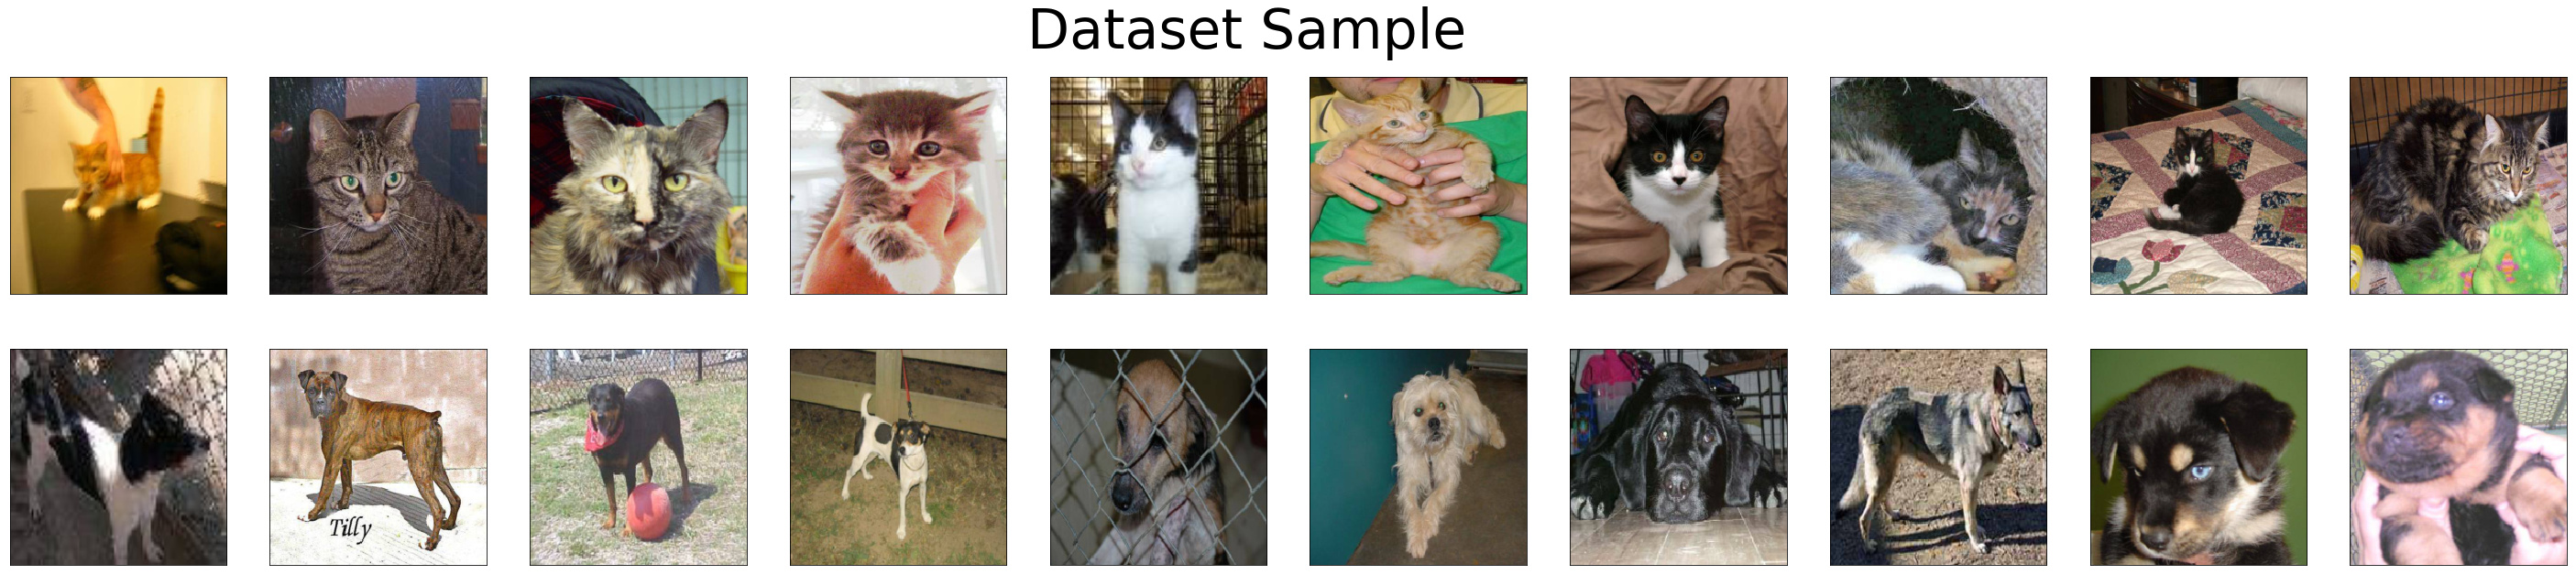

In [2]:
dataset_split = DatasetSplit('../data/dogs_and_cats_large/')
dataloaders = dataset_split.get_dataloaders()
dataset_split.display_sample()

The original dataset contains 25,000 images of dogs and cats (12,500 from each class) which we consider a "large" dataset. We have created a new dataset containing three subsets: a training set with 9000 samples of each class, a validation set with 1000 samples of each class, and finally a test set with 2500 samples of each class as shown below.

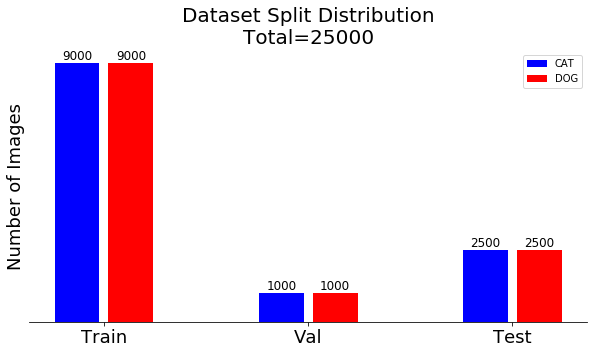

In [3]:
dataset_split.display_distribution()

So we have indeed 18000 training images, and then 2000 validation images and 5000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## VGG Architectures

We will use the VGG11 architecture, which is the smaller version of VGG architectures developed by [Karen Simonyan and Andrew Zisserman](https://arxiv.org/pdf/1409.1556.pdf) in 2014, a simple and widely used convnet architecture. The input of the network is an image of shape (224x224), that's why we display the dataset sample using such resolution. It has 133 millions of parameters and it is available in [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) PyTorch's module. Below is the architecture of the VGG16 model which is slightly bigger than VGG11.

![alt text](../images/vgg16.png "VGG16 Architecture")

You can construct a model with random parameters by calling its constructor, we can see it has two well differentiated parts, the feature extractor part (convolutional base) and the classifier one which last layer output is a vector of 1000 units.

In [4]:
model = models.vgg11()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

Since we are attacking a binary classification problem, we are replacing the classifier part of VGG11 network with a new binary classifier which last layer output is a single unit and a  sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [5]:
model.classifier = ModelUtils.get_binary_classifier()
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=128, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=128, out_features=1, bias=True)
  (7): Sigmoid()
)

For our training step, we'll go with the Adam optimizer with a small learning rate to ensure convergence. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [6]:
optimizer = Adam(model.parameters(), lr=0.00001)
loss = BCELoss()
runner = Runner(dataloaders, model, loss, optimizer)

We run the model for 10 epochs on the train and validation data and predict the test data at the end. The experiment took around 60 minutes.

In [7]:
runner.run()

Predictions: 100%|██████████| 313/313 [00:21<00:00, 16.18it/s, acc avg=86.7]


We can see how the model is converging slowly and we got a 86.7% of average accuracy in the test data.

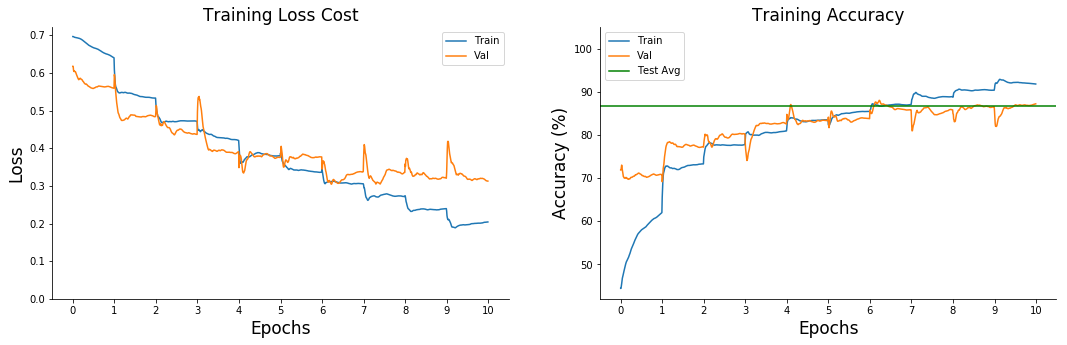

In [8]:
runner.display_result()

Let's save the result of the experiment so we can compare them with other experiments later.

In [9]:
runner.save_result('large_traditional_result.pth')

## Network-based Category

A common and highly effective approach to deep learning on image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

### VGG11 Pre-trained on ImageNet

This time we will initialize VGG11 on the parameters obtained after training it on the [ImageNet dataset](http://image-net.org/) (1.4 million labeled images and 1000 different classes). Below is a sample of the images.

![alt text](../images/imagenet.jpg "ImageNet Dataset")

ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We just need to construct the model with its pretrained flag enabled to initialize the model on ImageNet parameters.

In [3]:
model = models.vgg11(pretrained=True)
model.classifier = ModelUtils.get_binary_classifier()

### Quadrant 2 Strategy

As we are using a pre-trained model on a "large" target domain that is similar to the source domain, as suggested on the fine-tunning matrix below, we will be only training the model on the classifier part and the last 4 layers (conv block 5) of the feature extractor part, leaving the rest of the feature extractor frozen as we consider that have an state that is meaningful for our target domain.

![alt text](../images/fine_tuning_matrix.png "Fine-tunning Matrix")

In [4]:
ModelUtils.freeze(model)
for feature in range(16, 21):
    ModelUtils.unfreeze(model.features[feature])
ModelUtils.unfreeze(model.classifier)

We can apply differential learning with this new setting of the model, allowing to learn faster to the classifier using the default learning rate (0.001) and a smaller one to the unfrozen layers of the feature extractor part so it changes more slowly.

In [5]:
optimizer = Adam(
    [
        {'params': model.features.parameters(), 'lr': 0.0001},
        {'params': model.classifier.parameters()}
    ]
)
loss = BCELoss()
runner = Runner(dataloaders, model, loss, optimizer)

As before we repite the previous experiment running the model for 10 epochs on the train and validation data and predict the test data at the end. The experiment took around 30 minutes, half of the time that the traditional approach.

In [6]:
runner.run()

Predictions: 100%|██████████| 313/313 [00:43<00:00,  7.15it/s, acc avg=98.1]


We can see how the model has converged very quickly and and we got a 98.1% of average accuracy in the test data.

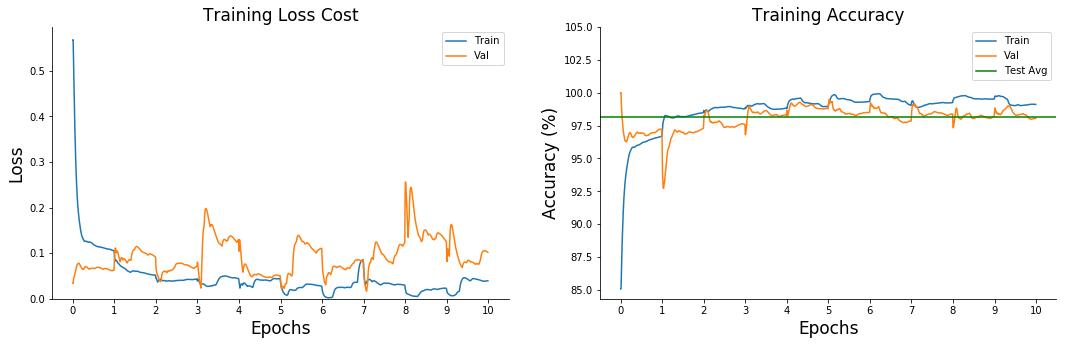

In [7]:
runner.display_result()

Let's also save the result of the experiment so we can compare them with other experiments later.

In [8]:
runner.save_result('large_transfer_result.pth')

## Traditional vs. Transer

As we can see bellow the model using the transfer learning approach has performed better, in all cases, than the model using the traditional one, getting higher start, higher slope and higher asymptote.

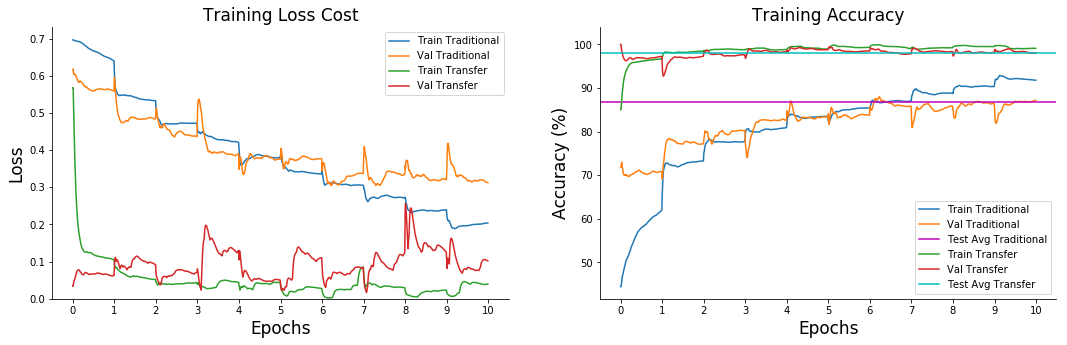

In [9]:
Runner.display_results('./large_traditional_result.pth', './large_transfer_result.pth')

We save our model knowledge with the result we have got so far without any hyper-parameter tunning apart from fine-tuning the model layers and applying differential learning on the unfrozen layers.

In [10]:
model_knowledge = runner.model.state_dict()
torch.save(model_knowledge, './best_large_model_state.pth')